**Right now, it is not clear whether the agent can generalize to unseen combinations. This is due to the fact that we did not yet disentangle the following.**

(1) The success on the unseen usages of subsequences of higher length (training contained [0, 1], testing contained [0, 1, 0], [0, 1, 0, 1])

(2) The success on the unseen usages of subsequences of smaller length (training contained [0, 1, 0], testing contained [0, 1], [0], [1], and etc)

(3) The success on unseen order (training contained [0, 1] only but testing contained [1, 0])


**Main obserations so far:**

(1) Concatenation beats the gated-attention in generalization abilities.

(2) PER shows the best performance on training data, but it does not always win in terms of generalization.

**Main conclusions so far:**

(1) Confirm the possibility to learn basic compositional structure of the language. But the sample efficiency is, indeed, low [refer baby ai].

(2) Gated-attention does not always outperform concatentation architecture for the compound instructions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import runner_hypothesis_synonyms as runner
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import pandas as pd
import re

from collections import defaultdict

import seaborn as sns
sns.set()

In [84]:
def generate_instruction_repetitions(instruction, from_target_subgoals=4, to_target_subgoals=6):
    instruction  = instruction.lower()
    num_src_subgoals = instruction.count(",")
    num_but_first    = instruction.count("but first")
    num_but_before   = instruction.count("but before")
    
    if num_but_first != 0 or num_but_before != 0:
        return []
    
    # Do not make repetitions of one object
    if num_src_subgoals == 0:
        return []
    
    # do not allow first and last be the same
    subgoals = re.split(", | but before", instruction)
    if subgoals[0] == subgoals[-1]:
        return []
    
    # Tricks
    instruction  = re.sub("but before", ";but before;but before", instruction)
    #instruction  = re.sub(",", ",,", instruction)
    subgoals   = re.split(", | ;but before;", instruction)
    subgoals   = [subgoal.strip() for subgoal in subgoals]
    
    n_subgoals = len(subgoals) 
    generated_subgoals = []
    for num_target_subgoals in range(from_target_subgoals, to_target_subgoals + 1):
        new_instruction = ""
        for ind in range(1, num_target_subgoals + 1):
            tgt_ind = (ind - 1) % n_subgoals
            is_last = ind == num_target_subgoals
            is_first = ind == 1
            
            if is_first:
                new_instruction += subgoals[tgt_ind]
            else:
                if subgoals[tgt_ind].count("but before") != 0:
                    new_instruction += " "
                else:
                    new_instruction += ", "
                new_instruction += subgoals[tgt_ind]
        
        # Remoe comma at the end if present
        if new_instruction[-1] == ",":
            new_instruction = new_instruction[:-1]
            
        new_instruction = new_instruction[0].upper() + new_instruction[1:]
        generated_subgoals.append(new_instruction)
        
    return generated_subgoals

In [240]:
def get_benchmarks(agent_folder):
    path = os.path.join(agent_folder(), "benchmarks.json")
    with open(path, mode="r") as f:
        return json.load(f)
    
def _mean_by_key(dictionary, target_key, default=30):
    values = []
    for key in dictionary.keys():
        values.append(dictionary[key][0][target_key])
        
    if len(values) == 0:
        return default
    else:
        return np.mean(values)
def _get_agent(params):
    agent = params["agent"]
    unseen_proportion = params["unseen_proportion"]
    seed = params["seed"]
    level = params["level"]
    conjunction = params["conjunction"]
    
    name, train_params, instr_params, start_train, bench_all, ep_folder, layouts_params = agent()
    instr_params["unseen_proportion"] = unseen_proportion
    instr_params["level"] = level
    instr_params["conjunctions"] = conjunction
    
    train_params["seed"] = seed
    instr_params["seed"] = seed
    layouts_params["seed"] = seed
    
    return lambda: (name, train_params, instr_params, start_train, bench_all, ep_folder, layouts_params)

def get_successful_instructions(benchmarks):
    targets_train = benchmarks["Instructions seen, layouts seen"]
    train_suc = [k for k, v in targets_train.items() if v[0]["success"] == 1]
    
    targets_high = benchmarks["Instructions high, layouts seen"]
    high_suc = [k for k, v in targets_high.items() if v[0]["success"] == 1]
    
    return train_suc, high_suc
def get_instructions(benchmarks):
    targets_train = benchmarks["Instructions seen, layouts seen"]
    targets_high = benchmarks["Instructions high, layouts seen"]
    
    return list(targets_train.keys()), list(targets_high.keys())
    

def get_train_suc_rate_mean(benchmarks):
    return _mean_by_key(benchmarks["Instructions seen, layouts seen"], "success")
def get_train_level_suc_rate_mean(benchmarks, level):
    train_sucs, _ = get_successful_instructions(benchmarks)
    all_train, _ = get_instructions(benchmarks)
    
    if level == 1:
        level_filter = lambda i: "but before" not in i and "but first" not in i
    elif level == 2:
        level_filter = lambda i: "but first" in i
    elif level == 3:
        level_filter = lambda i: "but before" in i
    
    num_all_train = len(list(filter(level_filter, all_train)))
    num_all_suc_train  = len(list(filter(level_filter, train_sucs)))
    
    if num_all_train != 0:
        return num_all_suc_train / num_all_train
    else:
        return 0.0
    
def get_train_traj_len_mean(benchmarks):
    targets = benchmarks["Instructions seen, layouts seen"]
    only_successful = {k:v for k, v in targets.items() if v[0]["success"] == 1}
    return _mean_by_key(only_successful, "steps")
def get_train_traj_len_opt(benchmarks):
    targets = benchmarks["Instructions seen, layouts seen"]
    only_successful = {k:v for k, v in targets.items() if v[0]["success"] == 1}
    return _mean_by_key(only_successful, "optimal")

def get_test_suc_rate_mean(benchmarks):
    return _mean_by_key(benchmarks["Instructions unseen, layouts seen"], "success")
def get_test_traj_len_mean(benchmarks):
    targets = benchmarks["Instructions unseen, layouts seen"]
    only_successful = {k:v for k, v in targets.items() if v[0]["success"] == 1}
    return _mean_by_key(only_successful, "steps")
def get_test_traj_len_opt(benchmarks):
    targets = benchmarks["Instructions unseen, layouts seen"]
    only_successful = {k:v for k, v in targets.items() if v[0]["success"] == 1}
    return _mean_by_key(only_successful, "optimal")

def get_high_suc_rate_mean(benchmarks):
    return _mean_by_key(benchmarks["Instructions high, layouts seen"], "success")
def get_high_repetitions_suc_rate_mean(benchmarks, frm=4, to=6):
    # Generate repetitions for training instructions
    training_instructions = list(benchmarks["Instructions seen, layouts seen"].keys())
    training_repetitions  = set()
    for instruction in training_instructions:
        training_repetitions = training_repetitions.union(set(generate_instruction_repetitions(instruction, frm, to)))
    
    #print(training_repetitions)
    
    # Remove from high instructions not repeated instructions
    high_instructions = set(list(benchmarks["Instructions high, layouts seen"].keys()))
    ok_instructions   = training_repetitions.intersection(high_instructions)
    
#     print("Training repetitions: {}".format(len(training_repetitions)))
#     print("Left training repetitions: {}".format(len(ok_instructions)))
#     print("High instructions: {}".format(len(high_instructions)))
#     print("Union of hight and training repetitions: {}".format(len(training_repetitions.union(high_instructions))))
    
#     print(training_repetitions.difference(high_instructions))
    
    ok_benchmarks = {}
    for instr in ok_instructions:
        ok_benchmarks[instr] = benchmarks["Instructions high, layouts seen"][instr]
    
    return _mean_by_key(ok_benchmarks, "success")

def get_high_traj_len_mean(benchmarks):
    targets = benchmarks["Instructions high, layouts seen"]
    only_successful = {k:v for k, v in targets.items() if v[0]["success"] == 1}
    return _mean_by_key(only_successful, "steps")
def get_high_traj_len_opt(benchmarks):
    targets = benchmarks["Instructions high, layouts seen"]
    only_successful = {k:v for k, v in targets.items() if v[0]["success"] == 1}
    return _mean_by_key(only_successful, "optimal")

In [253]:
level_1 = list(filter(lambda t: t["level"] == 3, runner.ALL_SETUPS))

In [254]:
iks = []
ys_train = defaultdict(lambda: defaultdict(list))
ys_test  = defaultdict(lambda: defaultdict(list))
ys_high  = defaultdict(lambda: defaultdict(list))
ys_high_repetitions  = defaultdict(lambda: defaultdict(list))
ys_high_repetitions_4  = defaultdict(lambda: defaultdict(list))
ys_high_repetitions_5  = defaultdict(lambda: defaultdict(list))
ys_high_repetitions_6  = defaultdict(lambda: defaultdict(list))

for unseen_proportion in runner.PARAMETERS["unseen_proportions"]:
    iks.append(unseen_proportion)
    props = list(filter(lambda t: t["unseen_proportion"] == unseen_proportion, level_1))
    
    instrcts = defaultdict(list)
    for element in props:
        try:
            agent = _get_agent(element)
            name  = agent()[0]
            benchmarks = get_benchmarks(agent()[5])

            instrcts[name].extend(list(benchmarks["Instructions seen, layouts seen"].keys()))

            train_instr = set(list(benchmarks["Instructions seen, layouts seen"].keys()))
            train_instr = train_instr.union(set(list(benchmarks["Instructions unseen, layouts seen"].keys())))
            test_instr  = set(list(benchmarks["Instructions high, layouts seen"].keys()))
        except:
            pass
        

        # Aggregation statistics
        ys_train[name]["success rate"].append(get_train_suc_rate_mean(benchmarks))
        ys_train[name]["steps"].append(get_train_traj_len_mean(benchmarks))
        ys_train[name]["optimal steps"].append(get_train_traj_len_opt(benchmarks))
        ys_train[name]["level1_succ"].append(get_train_level_suc_rate_mean(benchmarks, 1))
        ys_train[name]["level2_succ"].append(get_train_level_suc_rate_mean(benchmarks, 2))
        ys_train[name]["level3_succ"].append(get_train_level_suc_rate_mean(benchmarks, 3))

        ys_test[name]["success rate"].append(get_test_suc_rate_mean(benchmarks))
        ys_test[name]["steps"].append(get_test_traj_len_mean(benchmarks))
        ys_test[name]["optimal steps"].append(get_test_traj_len_opt(benchmarks))

        ys_high[name]["success rate"].append(get_high_suc_rate_mean(benchmarks))
        ys_high[name]["steps"].append(get_high_traj_len_mean(benchmarks))
        ys_high[name]["optimal steps"].append(get_high_traj_len_opt(benchmarks))
        
        ys_high_repetitions[name]["success rate"].append(get_high_repetitions_suc_rate_mean(benchmarks))
        ys_high_repetitions_4[name]["success rate"].append(get_high_repetitions_suc_rate_mean(benchmarks, 4, 4))
        ys_high_repetitions_5[name]["success rate"].append(get_high_repetitions_suc_rate_mean(benchmarks, 5, 5))
        ys_high_repetitions_6[name]["success rate"].append(get_high_repetitions_suc_rate_mean(benchmarks, 6, 6))


        # Instructions that succeeded or failed
        train_suc  = [k for k, v in benchmarks["Instructions seen, layouts seen"].items() if v[0]["success"] == 1]
        train_fail = [k for k, v in benchmarks["Instructions seen, layouts seen"].items() if v[0]["success"] == 0]

        test_suc  = [k for k, v in benchmarks["Instructions unseen, layouts seen"].items() if v[0]["success"] == 1]
        test_fail = [k for k, v in benchmarks["Instructions unseen, layouts seen"].items() if v[0]["success"] == 0]

        high_suc  = [k for k, v in benchmarks["Instructions high, layouts seen"].items() if v[0]["success"] == 1]
        high_fail = [k for k, v in benchmarks["Instructions high, layouts seen"].items() if v[0]["success"] == 0]

print("Number of training instructions: {}".format(len(train_instr)))
print("Number of testing instructions: {}".format(len(test_instr)))
#         print("----------------------------------")
#         print("Successful training:")
#         print(train_suc)
        
#         print("\nSuccessfull test")
#         print(test_suc)
        
#         print("\nFailed test")
#         print(test_fail)
        
#         print("\nSuccessfull high")
#         print(high_suc)
        
#         print("\nFailed test")
#         print(test_fail)
            
#         except:
#             pass
#     a = instrcts["(Dueling DQN + Cat + PER)"]
#     b = instrcts["(Dueling DQN + Cat)"]
#     print(len(a))
#     print(len(b))
#     print(a == b)
#     print()

Number of training instructions: 39
Number of testing instructions: 336


## Training Instructions

### Success Rate

Current level averaged success rate
                                  0
(Dueling DQN + Cat + PER)  1.000000
(Dueling DQN + Cat)        0.898942
(Dueling DQN + GA + PER)   0.943810
(Dueling DQN + GA)         0.729418

Level 1 averaged proportion of successfull instructions
                                  0
(Dueling DQN + Cat + PER)  1.000000
(Dueling DQN + Cat)        0.887482
(Dueling DQN + GA + PER)   0.950376
(Dueling DQN + GA)         0.763399

Level 2 averaged proportion of successfull instructions
                             0
(Dueling DQN + Cat + PER)  0.0
(Dueling DQN + Cat)        0.0
(Dueling DQN + GA + PER)   0.0
(Dueling DQN + GA)         0.0

Level 3 averaged proportion of successfull instructions
                                  0
(Dueling DQN + Cat + PER)  1.000000
(Dueling DQN + Cat)        0.914167
(Dueling DQN + GA + PER)   0.935000
(Dueling DQN + GA)         0.682500


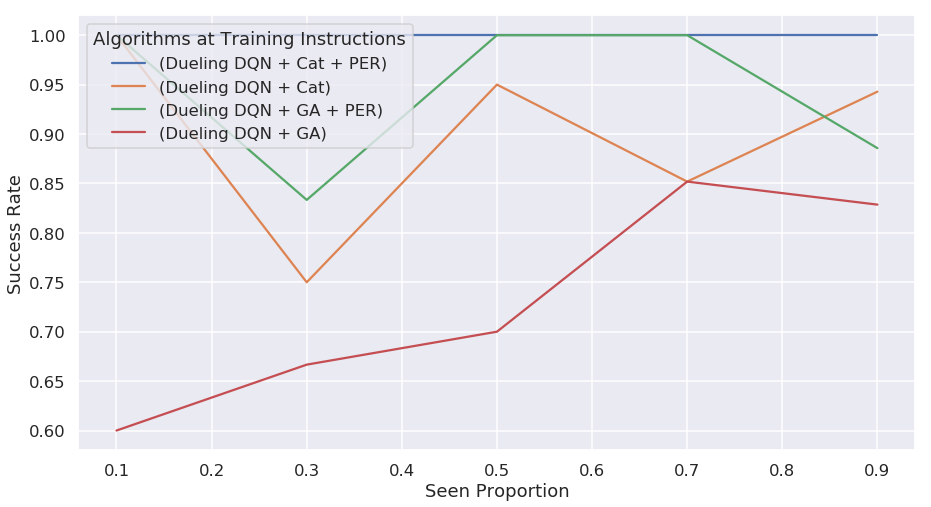

In [255]:
sns.set_context("talk")
plt.figure(figsize=(15,8))
mean_sucs = []
mean_sucs_1 = []
mean_sucs_2 = []
mean_sucs_3 = []
mean_sucs_n = []
for algo_name in sorted(ys_train.keys()):
    frame = pd.DataFrame(ys_train[algo_name]["success rate"], iks)
    frame.columns = ["Success Rate"]
    frame["Seen Proportion"] = 1 - frame.index
    frame["Level 1 Success Rate"] = ys_train[algo_name]["level1_succ"]
    frame["Level 2 Success Rate"] = ys_train[algo_name]["level2_succ"]
    frame["Level 3 Success Rate"] = ys_train[algo_name]["level3_succ"]
    sns.lineplot(x="Seen Proportion", y="Success Rate", data=frame, dashes=True)
    
    mean_sucs.append(np.mean(frame["Success Rate"]))
    mean_sucs_1.append(np.mean(frame["Level 1 Success Rate"]))
    mean_sucs_2.append(np.mean(frame["Level 2 Success Rate"]))
    mean_sucs_3.append(np.mean(frame["Level 3 Success Rate"]))
    mean_sucs_n.append(algo_name)
    
print("Current level averaged success rate")
frame = pd.DataFrame(mean_sucs, mean_sucs_n)
print(frame)#.sort_values(by=0, ascending=False))

print()
print("Level 1 averaged proportion of successfull instructions")
frame = pd.DataFrame(mean_sucs_1, mean_sucs_n)
print(frame)#.sort_values(by=0, ascending=False))

print()
print("Level 2 averaged proportion of successfull instructions")
frame = pd.DataFrame(mean_sucs_2, mean_sucs_n)
print(frame)#.sort_values(by=0, ascending=False))

print()
print("Level 3 averaged proportion of successfull instructions")
frame = pd.DataFrame(mean_sucs_3, mean_sucs_n)
print(frame)#.sort_values(by=0, ascending=False))


plt.legend(title='Algorithms at Training Instructions', loc='upper left', labels=list(sorted(ys_train.keys())))
plt.show()

### Trajectory Length

[15.925925925925926, 16.434782608695652, 15.642857142857142, 17.3, 13.333333333333334]
[16.037037037037038, 16.565217391304348, 15.642857142857142, 17.3, 13.333333333333334]


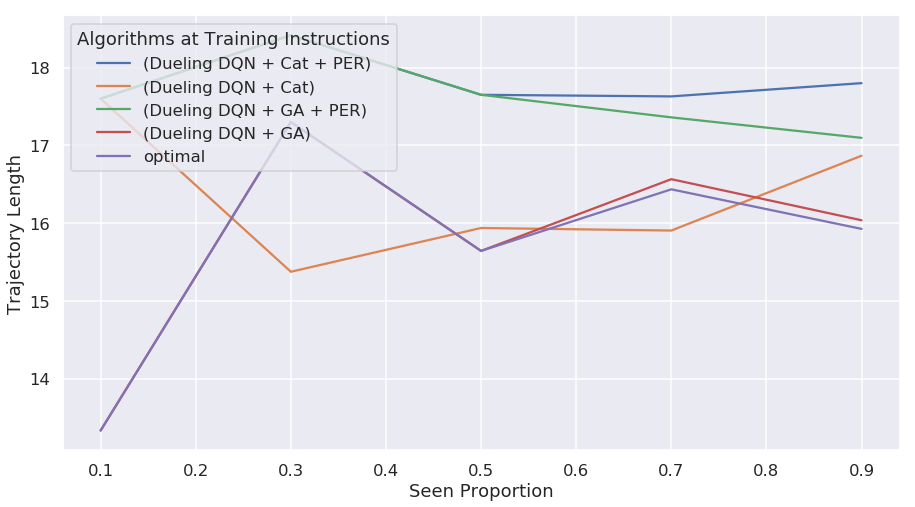

In [190]:
sns.set_context("talk")
plt.figure(figsize=(15,8))
for algo_name in sorted(ys_train.keys()):
    frame = pd.DataFrame(ys_train[algo_name]["success rate"], iks)
    frame.columns = ["Success Rate"]
    frame["Seen Proportion"] = 1 - frame.index
    frame["Trajectory Length"] = ys_train[algo_name]["steps"]
    #print(frame.head())
    #break
    sns.lineplot(x="Seen Proportion", y="Trajectory Length", data=frame, dashes=True)
    #sns.lineplot(x="Unseen Proportion", y="Trajectory Length", data=frame, legend="full")
    #plt.plot(iks, ys_train[algo_name]["success rate"])
    
frame = pd.DataFrame(ys_train[algo_name]["success rate"], iks)
frame.columns = ["Success Rate"]
frame["Seen Proportion"] = 1 - frame.index
frame["Trajectory Length"] = ys_train[algo_name]["optimal steps"]
print(ys_train[algo_name]["optimal steps"])
print(ys_train[algo_name]["steps"])
#print(frame.head())
#break
sns.lineplot(x="Seen Proportion", y="Trajectory Length", data=frame, dashes=False)
#sns.lineplot(x="Unseen Proportion", y="Trajectory Length", data=frame, legend="full")
#plt.plot(iks, ys_train[algo_name]["success rate"])

plt.legend(title='Algorithms at Training Instructions', loc='upper left', labels=list(sorted(ys_train.keys())) + ["optimal"])
plt.show()

## Testing Instructions

### Success Rate

                                  0
(Dueling DQN + Cat)        0.517326
(Dueling DQN + Cat + PER)  0.412940
(Dueling DQN + GA + PER)   0.293739
(Dueling DQN + GA)         0.292145


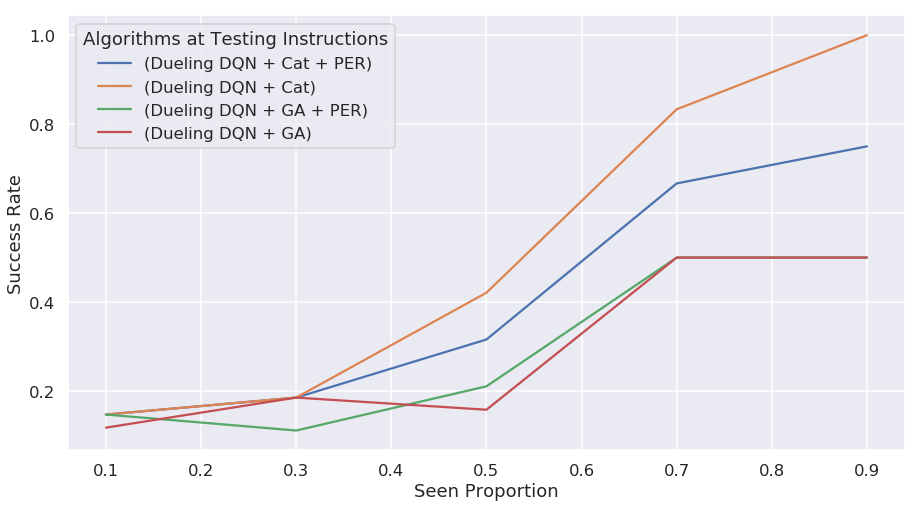

In [191]:
sns.set_context("talk")
plt.figure(figsize=(15,8))
mean_sucs = []
mean_sucs_n = []
for algo_name in sorted(ys_test.keys()):
    frame = pd.DataFrame(ys_test[algo_name]["success rate"], iks)
    frame.columns = ["Success Rate"]
    frame["Seen Proportion"] = 1 - frame.index
    frame["Trajectory Length"] = ys_test[algo_name]["steps"]
    sns.lineplot(x="Seen Proportion", y="Success Rate", data=frame, dashes=True)
    
    mean_sucs.append(np.mean(frame["Success Rate"]))
    mean_sucs_n.append(algo_name)
    
frame = pd.DataFrame(mean_sucs, mean_sucs_n)
print(frame.sort_values(by=0, ascending=False))

plt.legend(title='Algorithms at Testing Instructions', loc='upper left', labels=list(sorted(ys_test.keys())))
plt.show()

## Higher Sub-Goals

### Success Rate for All

Averaged over all training proportions
                                  0
(Dueling DQN + Cat + PER)  0.104167
(Dueling DQN + GA + PER)   0.082143
(Dueling DQN + Cat)        0.059524
(Dueling DQN + GA)         0.048214

Scores for the biggest proportion
                                  0
(Dueling DQN + Cat + PER)  0.175595
(Dueling DQN + GA + PER)   0.133929
(Dueling DQN + Cat)        0.089286
(Dueling DQN + GA)         0.074405


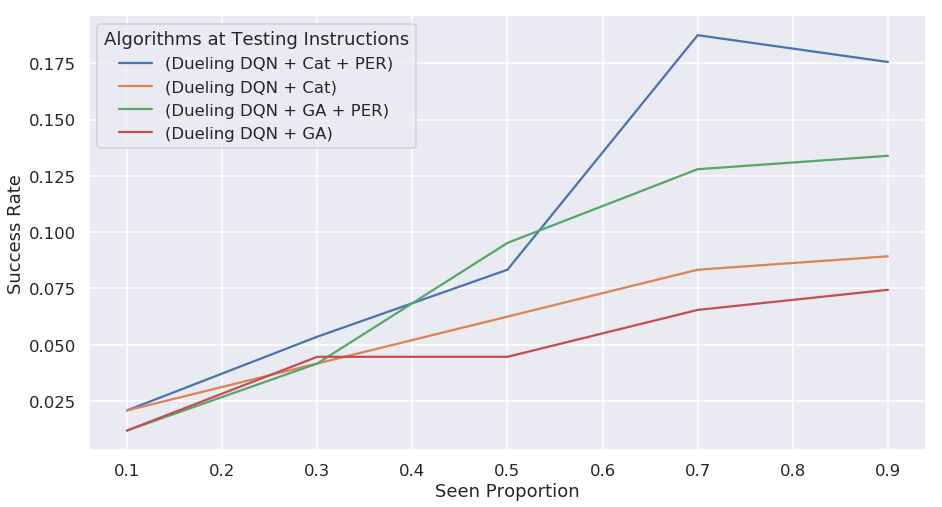

In [192]:
sns.set_context("talk")
plt.figure(figsize=(15,8))
mean_sucs = []
mean_sucs_n = []
biggest     = []

for algo_name in sorted(ys_high.keys()):
    frame = pd.DataFrame(ys_high[algo_name]["success rate"], iks)
    frame.columns = ["Success Rate"]
    frame["Seen Proportion"] = 1 - frame.index
    frame["Trajectory Length"] = ys_high[algo_name]["steps"]
    sns.lineplot(x="Seen Proportion", y="Success Rate", data=frame, dashes=True)
    
    biggest.append(frame.loc[0.1]["Success Rate"])
    mean_sucs.append(np.mean(frame["Success Rate"]))
    mean_sucs_n.append(algo_name)
    
frame = pd.DataFrame(mean_sucs, mean_sucs_n)
print("Averaged over all training proportions")
print(frame.sort_values(by=0, ascending=False))

print()
print("Scores for the biggest proportion")
frame = pd.DataFrame(biggest, mean_sucs_n)
print(frame.sort_values(by=0, ascending=False))

plt.legend(title='Algorithms at Testing Instructions', loc='upper left', labels=list(sorted(ys_high.keys())))
plt.show()

### Success rate for Training Repetitions in High Order (All)

In [156]:
target_data_structure = ys_high_repetitions

sns.set_context("talk")
plt.figure(figsize=(15,8))
mean_sucs = []
mean_sucs_n = []
biggest_proportion = []
for algo_name in sorted(target_data_structure.keys()):
    frame = pd.DataFrame(target_data_structure[algo_name]["success rate"], iks)
    frame.columns = ["Success Rate"]
    frame["Seen Proportion"] = 1 - frame.index
    #frame["Trajectory Length"] = ys_high[algo_name]["steps"]
    #sns.lineplot(x="Seen Proportion", y="Success Rate", data=frame, dashes=True)
    
    biggest_proportion.append(frame.loc[0.1]["Success Rate"])
    mean_sucs.append(np.mean(frame["Success Rate"]))
    mean_sucs_n.append(algo_name)
    
print("Averaged for all proportions")
frame = pd.DataFrame(mean_sucs, mean_sucs_n)
print(frame.sort_values(by=0, ascending=False))

print()
print("The biggest proportion")
frame = pd.DataFrame(biggest_proportion, mean_sucs_n)
print(frame.sort_values(by=0, ascending=False))

# plt.legend(title='Algorithms at High Instructions of Repetitions', loc='upper left', labels=list(sorted(target_data_structure.keys())))
# plt.show()

Averaged for all proportions
                                  0
(Dueling DQN + Cat + PER)  0.578485
(Dueling DQN + GA)         0.478485
(Dueling DQN + GA + PER)   0.383636
(Dueling DQN + Cat)        0.151212

The biggest proportion
                                  0
(Dueling DQN + Cat + PER)  0.575758
(Dueling DQN + GA + PER)   0.484848
(Dueling DQN + Cat)        0.272727
(Dueling DQN + GA)         0.166667


<Figure size 1080x576 with 0 Axes>

### Success rate for Training Repetitions in High Order (4)

In [157]:
target_data_structure = ys_high_repetitions_4

sns.set_context("talk")
plt.figure(figsize=(15,8))
mean_sucs = []
mean_sucs_n = []
biggest_proportion = []
for algo_name in sorted(target_data_structure.keys()):
    frame = pd.DataFrame(target_data_structure[algo_name]["success rate"], iks)
    frame.columns = ["Success Rate"]
    frame["Seen Proportion"] = 1 - frame.index
    #frame["Trajectory Length"] = ys_high[algo_name]["steps"]
    #sns.lineplot(x="Seen Proportion", y="Success Rate", data=frame, dashes=True)
    
    biggest_proportion.append(frame.loc[0.1]["Success Rate"])
    mean_sucs.append(np.mean(frame["Success Rate"]))
    mean_sucs_n.append(algo_name)
    
print("Averaged for all proportions")
frame = pd.DataFrame(mean_sucs, mean_sucs_n)
print(frame.sort_values(by=0, ascending=False))

print()
print("The biggest proportion")
frame = pd.DataFrame(biggest_proportion, mean_sucs_n)
print(frame.sort_values(by=0, ascending=False))

# plt.legend(title='Algorithms at High Instructions of Repetitions', loc='upper left', labels=list(sorted(target_data_structure.keys())))
# plt.show()

Averaged for all proportions
                                  0
(Dueling DQN + Cat + PER)  0.547424
(Dueling DQN + GA)         0.547424
(Dueling DQN + GA + PER)   0.452576
(Dueling DQN + Cat)        0.164394

The biggest proportion
                                  0
(Dueling DQN + Cat + PER)  0.545455
(Dueling DQN + GA)         0.500000
(Dueling DQN + GA + PER)   0.454545
(Dueling DQN + Cat)        0.363636


<Figure size 1080x576 with 0 Axes>

### Success rate for Training Repetitions in High Order (5)

In [158]:
target_data_structure = ys_high_repetitions_5

sns.set_context("talk")
plt.figure(figsize=(15,8))
mean_sucs = []
mean_sucs_n = []
biggest_proportion = []
for algo_name in sorted(target_data_structure.keys()):
    frame = pd.DataFrame(target_data_structure[algo_name]["success rate"], iks)
    frame.columns = ["Success Rate"]
    frame["Seen Proportion"] = 1 - frame.index
    #frame["Trajectory Length"] = ys_high[algo_name]["steps"]
    #sns.lineplot(x="Seen Proportion", y="Success Rate", data=frame, dashes=True)
    
    biggest_proportion.append(frame.loc[0.1]["Success Rate"])
    mean_sucs.append(np.mean(frame["Success Rate"]))
    mean_sucs_n.append(algo_name)
    
print("Averaged for all proportions")
frame = pd.DataFrame(mean_sucs, mean_sucs_n)
print(frame.sort_values(by=0, ascending=False))

print()
print("The biggest proportion")
frame = pd.DataFrame(biggest_proportion, mean_sucs_n)
print(frame.sort_values(by=0, ascending=False))

# plt.legend(title='Algorithms at High Instructions of Repetitions', loc='upper left', labels=list(sorted(target_data_structure.keys())))
# plt.show()

Averaged for all proportions
                                  0
(Dueling DQN + Cat + PER)  0.644242
(Dueling DQN + GA)         0.444242
(Dueling DQN + GA + PER)   0.327576
(Dueling DQN + Cat)        0.061364

The biggest proportion
                                  0
(Dueling DQN + Cat + PER)  0.454545
(Dueling DQN + GA + PER)   0.454545
(Dueling DQN + Cat)        0.181818
(Dueling DQN + GA)         0.000000


<Figure size 1080x576 with 0 Axes>

### Success rate for Training Repetitions in High Order (6)

In [159]:
target_data_structure = ys_high_repetitions_6

sns.set_context("talk")
plt.figure(figsize=(15,8))
mean_sucs = []
mean_sucs_n = []
biggest_proportion = []
for algo_name in sorted(target_data_structure.keys()):
    frame = pd.DataFrame(target_data_structure[algo_name]["success rate"], iks)
    frame.columns = ["Success Rate"]
    frame["Seen Proportion"] = 1 - frame.index
    #frame["Trajectory Length"] = ys_high[algo_name]["steps"]
    #sns.lineplot(x="Seen Proportion", y="Success Rate", data=frame, dashes=True)
    
    biggest_proportion.append(frame.loc[0.1]["Success Rate"])
    mean_sucs.append(np.mean(frame["Success Rate"]))
    mean_sucs_n.append(algo_name)
    
print("Averaged for all proportions")
frame = pd.DataFrame(mean_sucs, mean_sucs_n)
print(frame.sort_values(by=0, ascending=False))

print()
print("The biggest proportion")
frame = pd.DataFrame(biggest_proportion, mean_sucs_n)
print(frame.sort_values(by=0, ascending=False))

# plt.legend(title='Algorithms at High Instructions of Repetitions', loc='upper left', labels=list(sorted(target_data_structure.keys())))
# plt.show()

Averaged for all proportions
                                  0
(Dueling DQN + Cat + PER)  0.543788
(Dueling DQN + GA)         0.443788
(Dueling DQN + GA + PER)   0.370758
(Dueling DQN + Cat)        0.227879

The biggest proportion
                                  0
(Dueling DQN + Cat + PER)  0.727273
(Dueling DQN + GA + PER)   0.545455
(Dueling DQN + Cat)        0.272727
(Dueling DQN + GA)         0.000000


<Figure size 1080x576 with 0 Axes>